# Two-Qubit State Tomography #

## Preamble ##

We start by importing a few Python 2/3 compatability features and configuring Jupyter Notebook to use inline plotting.

In [1]:
from __future__ import division, print_function
from future.builtins import next
%matplotlib inline

C:\Users\cgran\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Next, we import a few Python standard library packages that will make our lives much easier.

In [2]:
import itertools as it
import pickle
from functools import partial

We also import the scientific computing libraries that we need.

In [3]:
import numpy as np
import ipyparallel
import qinfer as qi
import qutip as qt

We finish the preamble by importing and configuring plotting support.

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Notation ##

We use QuTiP to define the Pauli group.

In [5]:
Id, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()

We can then expand the unitary operators $U_{\theta,\mu} = \left.\theta\mu\right)_x$, using the identity that $e^{-i \theta \sigma_\mu} = \cos(\theta / 2)  \mathbb{1} - \sin(\theta / 2) \sigma_\mu$. We will use these below to define measurements of our system.

In [6]:
pi_x   = np.cos(np.pi/2.) * Id - 1.j * np.sin(np.pi/2.) * X
pi_x_2 = np.cos(np.pi/4.) * Id - 1.j * np.sin(np.pi/4.) * X
pi_y_2 = np.cos(np.pi/4.) * Id - 1.j * np.sin(np.pi/4.) * Y

Finally, we'll define the action of a unitary $U$ on an operator $X$ as $U \bullet X \mathrel{:=} U X U^\dagger$.

In [7]:
def act(U, H):
    return U * H * U.dag()

# Single Qubit Tests

We start analyzing the single-qubit data by defining a basis for representing Hermitian operators as well as a QInfer model and prior distribution.

In [8]:
basis = qi.tomography.pauli_basis(1)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
prior = qi.tomography.GinibreDistribution(basis)
basis

<TomographyBasis pauli_basis dims=[2] at 0x783cbe0>

Critically, our new basis is a basis of Hermitian operators, such that the representation of any other Hermitian operator is a real vector in this basis. If we attempt to expand a non-Hermitian operator, however, this basis will only represent the Hermitian part. For instance, the operator $U_{\pi / 2, y} = \frac{1}{\sqrt{2}} (\mathbb{1} - i \sigma_y)$ defined above is not Hermitian due to the factor of $i$ in the coefficient of $\sigma_y$. To wit, representing $U_{\pi / 2, y}$ in our tomography basis keeps only the identity component: 

In [9]:
basis.state_to_modelparams(pi_y_2)

array([ 1.,  0.,  0.,  0.])

This is wholly consistent, however, with the use of our tomography basis to represent Born's rule. That is, we are interested in the probability $\Tr(E \rho)$ of observing a measurement effect $E$ for the hypothetical state $\rho$. In our case, $E$ is some rotation of a fixed *fiducial measurement*, which we take to be $E_0 = |0\rangle \langle0|$ by convention.

In [10]:
fiducial_measurement = basis.modelparams_to_state(np.array([1,0,0,1])/np.sqrt(2))
fiducial_measurement

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0.  0.]]

We can then define our measurements in terms of the unitary rotations $U$ which transform $E_0$ into each measurement effect. For later convienence in making plots, we also assign a name to each measurement. 

In [11]:
single_measurement_list = [Id, pi_x, pi_x_2, pi_y_2]
single_measurement_labels = [r'\mathbb{1}', r'U_{\pi, x}', r'U_{\pi / 2, x}', r'U_{\pi / 2, y}']

With this in place, we can then convert each of the measurements defined above by unitary transformations into measurement effects expanded in our tomography basis. In particular, we let $E_i = U^\dagger_i E_0 U_i$ for each unitary operator $U_i$.

In [12]:
expparams = np.empty((len(single_measurement_list),), dtype=model.expparams_dtype)

expparams['meas'] = [
    basis.state_to_modelparams(act(op.dag(), fiducial_measurement))
    for op in single_measurement_list
]
expparams['n_meas'] = 50

To performance test over this choice, we define a heuristic that cycles over each of the four allowed measurement operators above.

In [13]:
def cycle_heuristic(expparams):
    
    def heuristic(updater):
        return partial(next, it.cycle(expparams[:, np.newaxis]))
    
    return heuristic

In [14]:
perf = qi.perf_test_multiple(50,
    model, 500, prior,
    len(expparams), cycle_heuristic(expparams),
    progressbar=qi.IPythonProgressBar
)

C:\Users\cgran\Anaconda2\lib\site-packages\qinfer-1.0-py2.7.egg\qinfer\utils.py:268: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
C:\Users\cgran\Anaconda2\lib\site-packages\qinfer-1.0-py2.7.egg\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (4.54458300822). Resampling is likely to fail. Consider adding particles, or resampling more often.
C:\Users\cgran\Anaconda2\lib\site-packages\qinfer-1.0-py2.7.egg\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.41754983742). Resampling is likely to fail. Consider adding particles, or resampling more often.


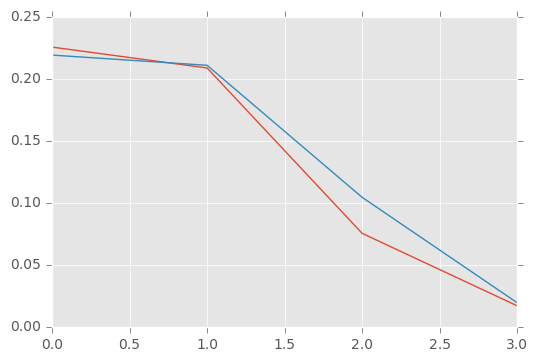

In [15]:
plt.plot(np.median(perf['loss'], axis=0))
plt.plot(np.mean(perf['loss'], axis=0))

In [16]:
GS_Single_Qubit_data = pickle.load(open("GS_Single_Qubit_data","r"))
exp_data=GS_Single_Qubit_data["Measurements"]

In [17]:
n_shots = 100
number_of_batches = 1
expparams['n_meas'] = n_shots // number_of_batches

true_state = qt.Qobj([[0, 0],[0, 1]])

true_mps = basis.state_to_modelparams(true_state)[np.newaxis, :]
# exp_data=np.round(np.multiply(GS_2[0:32],expparams['n_meas'][0]*number_of_batches))

true_state

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.  0.]
 [ 0.  1.]]

In [18]:
ideal_data = [0] * 4

for batch in range(number_of_batches):
    i=0
    for experiment in expparams[:, np.newaxis]:
        datum = model.simulate_experiment(true_mps, experiment)
        ideal_data[i]+=datum
        i+=1

([<matplotlib.axis.XTick at 0xdb39128>,
 <a list of 4 Text xticklabel objects>)

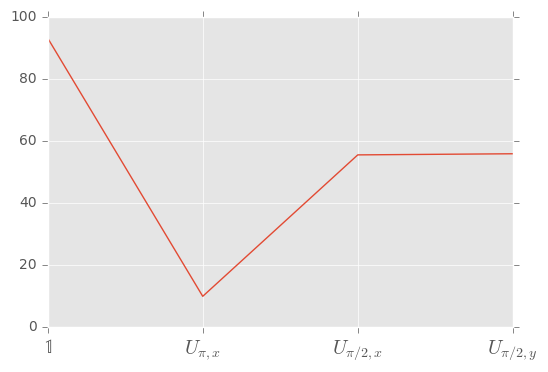

In [19]:
fixed_data=[0, 0, 0, 0 ]
for i in range(100):
    fixed_data += exp_data[i][0:4]

plt.plot(fixed_data)
plt.xticks(range(4), map("${}$".format, single_measurement_labels), fontsize='x-large')

([<matplotlib.axis.XTick at 0xe14a2b0>,
 <a list of 4 Text xticklabel objects>)

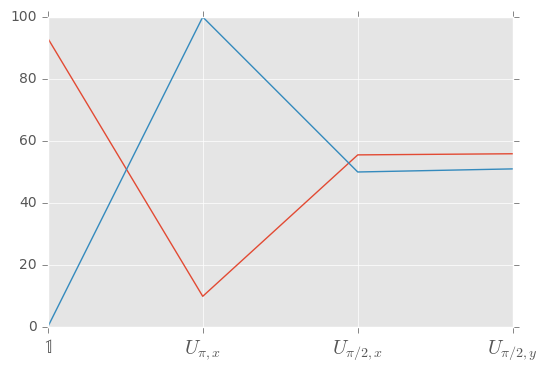

In [20]:
plt.plot(fixed_data)
plt.plot(np.divide(ideal_data, 1))

plt.xticks(range(4), map("${}$".format, single_measurement_labels), fontsize='x-large')

In [21]:
exp_data[i]

array([ 0.94461237,  0.09973717,  0.55748582,  0.53758251,  0.08744878,
        0.01657512,  0.09271851,  0.09154556,  0.53550198,  0.04694897,
        0.29084936,  0.32180958,  0.55564396,  0.0537402 ,  0.30032571,
        0.26271709,  0.92596929,  0.0839345 ,  0.53677753,  0.53864769,
        0.07751034,  0.00669977,  0.07431107,  0.09735824,  0.51672427,
        0.06793619,  0.27566732,  0.29012558,  0.52542366,  0.05656296,
        0.2916638 ,  0.29467604])

In [22]:
# updater = qi.SMCUpdater(model, 10000, prior)
# # updater = qi.SMCUpdater(parallel_model, 10000, prior)

# for batch in range(number_of_batches):
#     i=0
#     for experiment in expparams[:, np.newaxis]:
#         datum=np.round(exp_data[i] * experiment['n_meas'] / number_of_batches)
#         updater.update(datum, experiment)
#         i+=1

In [23]:
updater = qi.SMCUpdater(model, 10000, prior)

# Pick out "rows" of the data corresponding to looping
# over the four measurements defined above.
for data_repetition in np.round(n_shots * np.array(exp_data)[:, :4] / number_of_batches):
    for experiment, datum in zip(experiment[:, np.newaxis], data_repetition):
        updater.update(datum, experiment)

In [24]:
rho_est = basis.modelparams_to_state(updater.est_mean())

In [25]:
(rho_est ** 2).tr()

0.87259311293471

In [26]:
rho_est

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.49839297+0.j         -0.43151496-0.00942417j]
 [-0.43151496+0.00942417j  0.50160703+0.j        ]]

In [33]:
updater.est_mean() * np.sqrt(2)

array([ 1.        , -0.86302992,  0.01884833, -0.00321407])

In [28]:
particle_purities = np.array([
    (rho ** 2).tr()
    for rho in basis.modelparams_to_state(updater.particle_locations)
])

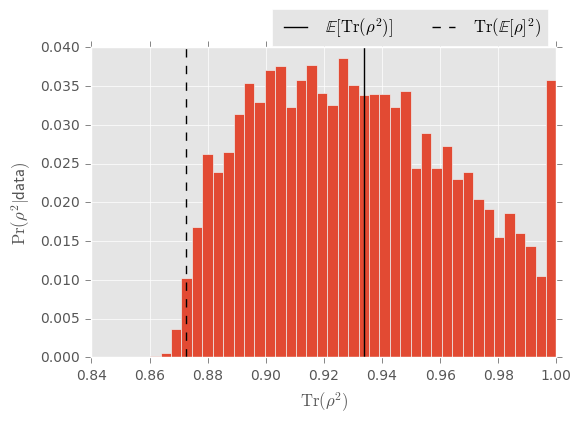

In [32]:
plt.hist(particle_purities, weights=updater.particle_weights, bins=40)
plt.xlabel(r'$\operatorname{Tr}(\rho^2)$')
plt.ylabel(r'$\Pr(\rho^2 | \mathsf{data})$')
plt.xlim(xmax=1)

ylim = plt.ylim()
plt.vlines(np.mean(particle_purities), *ylim, label=r'$\mathbb{E}[\operatorname{Tr}(\rho^2)]$')
plt.vlines((rho_est ** 2).tr(), *ylim, linestyle='--', label=r'$\operatorname{Tr}(\mathbb{E}[\rho]^2)$')
plt.ylim(*ylim)
plt.legend(ncol=2, bbox_to_anchor=(1, 1.15))

In [35]:
rho_x, rho_y, rho_z = np.sqrt(2) * updater.particle_locations.T[1:]
rho_r = np.sqrt(rho_x ** 2 + rho_y ** 2 + rho_z ** 2)
rho_theta = np.arccos(rho_z / rho_r)
rho_phi = np.arctan2(rho_y, rho_x)

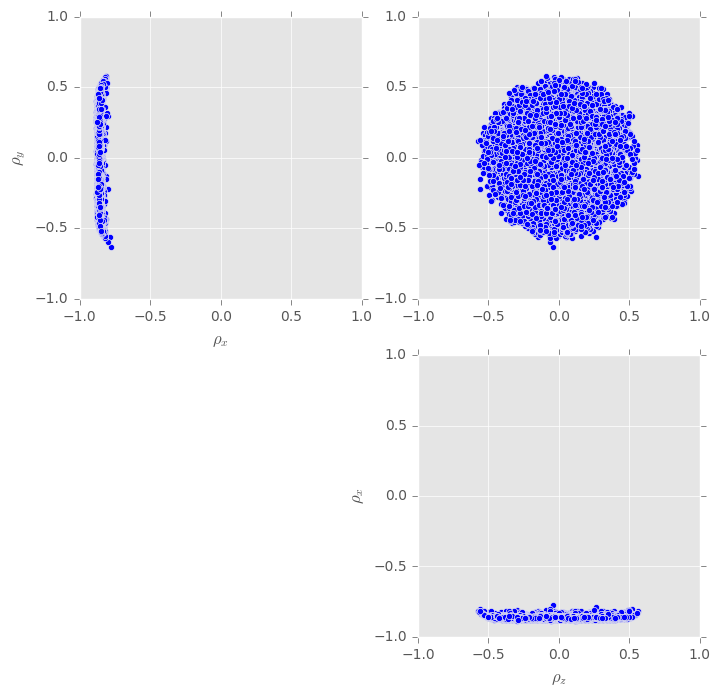

In [51]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

plt.sca(axes[0][0])
plt.scatter(rho_x, rho_y)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r'$\rho_x$')
plt.ylabel(r'$\rho_y$')
plt.gca().set_aspect('equal')

plt.sca(axes[0][1])
plt.scatter(rho_z, rho_y)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')

plt.sca(axes[1][1])
plt.scatter(rho_z, rho_x)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r'$\rho_z$')
plt.ylabel(r'$\rho_x$')
plt.gca().set_aspect('equal')

fig.delaxes(axes[1][0])

(array([ 0.00695921,  0.0747738 ,  0.11870204,  0.14652164,  0.15972904,
         0.14405402,  0.14638194,  0.12744709,  0.06395772,  0.01147348]),
 array([ 0.30936347,  0.34775899,  0.38615451,  0.42455003,  0.46294555,
         0.50134107,  0.53973659,  0.57813211,  0.61652764,  0.65492316,
         0.69331868]),
 <a list of 10 Patch objects>)

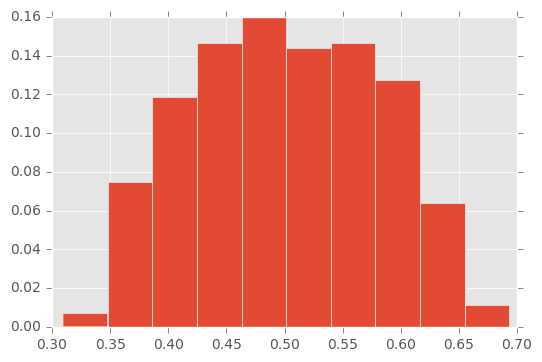

In [37]:
plt.hist(rho_theta / np.pi, weights=updater.particle_weights)

(array([  4.60340031e-01,   4.67892139e-16,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          5.39659969e-01]),
 array([ -9.99995943e-01,  -7.99998251e-01,  -6.00000559e-01,
         -4.00002866e-01,  -2.00005174e-01,  -7.48181717e-06,
          1.99990211e-01,   3.99987903e-01,   5.99985595e-01,
          7.99983287e-01,   9.99980980e-01]),
 <a list of 10 Patch objects>)

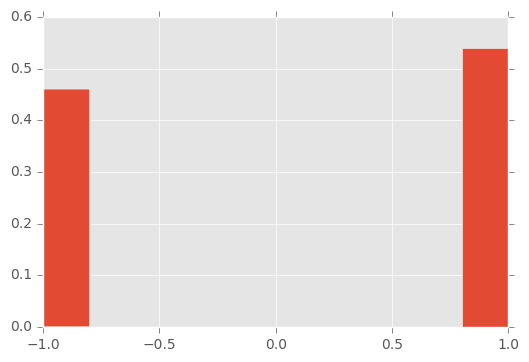

In [38]:
plt.hist(rho_phi / np.pi, weights=updater.particle_weights)

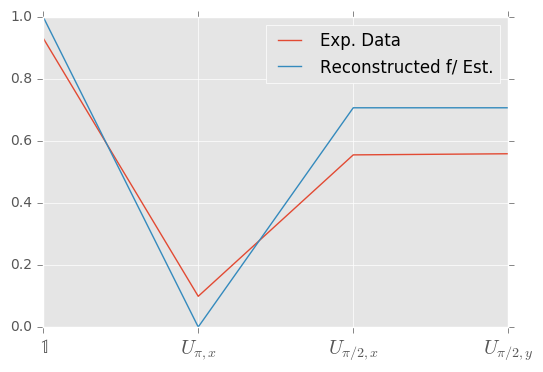

In [58]:
plt.plot(fixed_data / 100, label='Exp. Data')
plt.plot([(E * rho_est).tr() for E in single_measurement_list], label='Reconstructed f/ Est.')

plt.xticks(range(4), map("${}$".format, single_measurement_labels), fontsize='x-large')
plt.legend()

# Two-Qubit Tests

In [7]:
basis = qi.tomography.pauli_basis(2)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
fid_prior = qi.tomography.GinibreDistribution(basis, rank=2)
# prior = qi.tomography.GADFLIDistribution(
#     fid_prior,
#     mean=fiducial_state
# )
prior = fid_prior

In [8]:
fiducial_measurement = qt.ket2dm(qt.tensor([qt.basis(2, 0)] * 2))
fiducial_measurement

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

In [9]:
def PreRotationMeasurements(single_qubit_ops, core_measurement, n_qubits=2, include_conjugate=True):
    """Generate a set of measurement operators based on a set of rotations of a core measurement,
    optionally including the conjugate of the same measurements as well.  Easily generates the sets in
    http://journals.aps.org/pra/pdf/10.1103/PhysRevA.81.062325 using [I, PiX, PiX2, PiY2], M = |00><00|,
    include_conjugate=True"""

    assert (n_qubits == 2) #May optionally generalize later

    FullMeasurementList = []
    
    for m1 in single_qubit_ops:
        for m2 in single_qubit_ops:
            FullMeasurementList.append(np.dot(np.conj(np.kron(m1, m2).T), np.dot(core_measurement, np.kron(m1, m2))))

    if (include_conjugate):
        FullMeasurementList.extend([np.conj(m) for m in FullMeasurementList])

    return FullMeasurementList

beta_vec=[0.32182797213542436,0.20388382857043799,0.26690981910827039,0.17047277839951108]
# beta_vec=[0.25,.25,.25,.25]
CoreMeasurement = (np.kron(Id, Id) + np.kron(Z, Id) + np.kron(Id,Z) + np.kron(Z,Z))

CoreMeasurement=np.multiply(CoreMeasurement,beta_vec)

FullMeasurementList = PreRotationMeasurements(SingleMeasurementList, CoreMeasurement, 
                                              n_qubits=2, include_conjugate=True)

In [10]:
meas_ops=[]
meas_ops += [qt.Qobj(op) for op in FullMeasurementList]

expparams = np.empty((len(meas_ops),),dtype=model.expparams_dtype)

expparams['meas'] = [basis.state_to_modelparams(op) for op in meas_ops]
expparams['n_meas'] = 50

In [539]:
perf = qi.perf_test_multiple(50,
    model, 6000, prior,
    len(expparams),
    heuristic_class=cycle_heuristic(expparams, shuffle=True),
#     heuristic_class=partial(
#         qi.tomography.RandomPauliHeuristic,
#         other_fields={
#             'n_meas': 50
#         }
#     ),
    progressbar=qi.IPythonProgressBar,
    extra_updater_args={
        'resample_thresh': 0.1
    },
    # Test not just how well we perform in general, but for the state of interest.
    true_mps=true_mps
)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
C:\Users\cgran\Anaconda2\lib\site-packages\qinfer-1.0-py2.7.egg\qinfer\utils.py:268: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
C:\Users\cgran\Anaconda2\lib\site-packages\qinfer-1.0-py2.7.egg\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (9.07896554636). Resampling is likely to fail. Consider adding particles, or resampling more often.


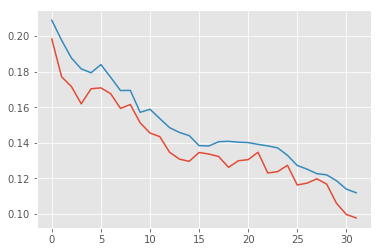

In [714]:
plt.plot(np.median(perf['loss'], axis=0))
plt.plot(np.mean(perf['loss'], axis=0))

(0.0, 10.0)

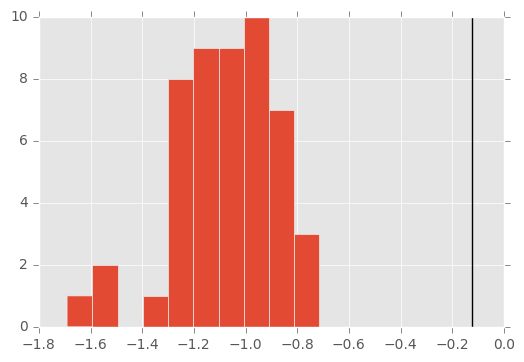

In [19]:
plt.hist(np.log10(perf['loss'][:, -1]))
ylim = plt.ylim()
plt.vlines(np.log10(perf['loss'][:, 0].mean()), *ylim)
plt.ylim(*ylim)

## Data Handling ##

In [20]:
data_store = h5py.File('./Fiducials.hdf5')
GS_2 = data_store['GS_2'].value

In [21]:
n_shots = 1000

In [22]:
counts = (GS_2 * n_shots).astype(int)

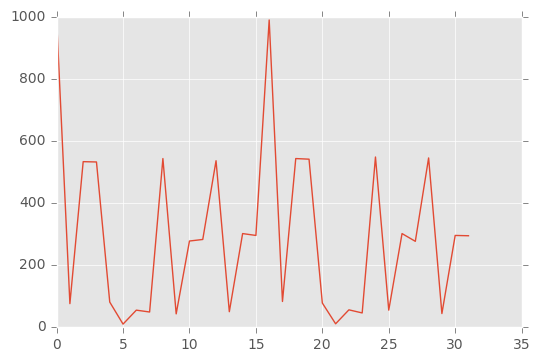

In [23]:
plt.plot(counts)

## Updater Loop ##

In [12]:
GS_data=np.load("GS_data.npy")
EE_data=np.load("EE_data.npy")
exp_data=EE_data

In [13]:
expparams['n_meas'] = 25
number_of_batches = 200

true_state = qt.tensor(qt.Qobj([[0, 0],[0, 1]]),qt.Qobj([[0, 0],[0, 1]]))

true_mps = basis.state_to_modelparams(true_state)[np.newaxis, :]
# exp_data=np.round(np.multiply(GS_2[0:32],expparams['n_meas'][0]*number_of_batches))

print(exp_data)
true_state

[ 0.00135996  0.08076701  0.052682    0.02520824  0.09174967  0.91999155
  0.55405832  0.51292121  0.03480982  0.41118087  0.26868175  0.19832611
  0.04374498  0.49566964  0.27591583  0.28463107  0.00326315  0.09587489
  0.03462633  0.03297723  0.07358807  0.9487208   0.54751977  0.58515699
  0.03821165  0.55067654  0.25551489  0.26195085  0.03234245  0.4657218
  0.23641747  0.26281347]


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  1.]]

In [14]:
ideal_data = np.zeros_like(GS_2)

for idx_batch in range(number_of_batches):
    for idx_experiment, experiment in enumerate(expparams[:, np.newaxis]):
        datum = model.simulate_experiment(true_mps, experiment)
        ideal_data[idx_experiment] += datum

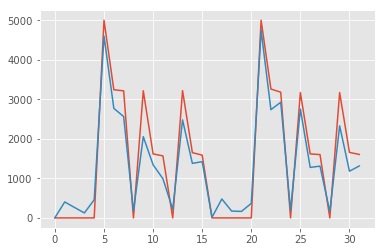

In [15]:
plt.plot(ideal_data)
plt.plot(exp_data*5000)
# plt.show()
# plt.plot(np.abs(ideal_data-exp_data)/3000)

In [16]:
import ipyparallel as ipp

ipp

<module 'ipyparallel' from '/Users/jcolless/anaconda/lib/python2.7/site-packages/ipyparallel/__init__.pyc'>

In [17]:
# from IPython.parallel import serialize
import dill
import dill as pkl

rc = ipp.Client()

# print(rc.ids)
dview = rc[:]

# dview.use_dill()
parallel_model = qi.DirectViewParallelizedModel(model, dview, purge_client=False, serial_threshold=None)

basis = qi.tomography.pauli_basis(2)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))


prior = qi.tomography.GinibreDistribution(basis)

ipyparallel.serialize
dill

<module 'dill' from '/Users/jcolless/anaconda/lib/python2.7/site-packages/dill/__init__.pyc'>

In [18]:
# updater = qi.SMCUpdater(model, 10000, prior)
updater = qi.SMCUpdater(parallel_model, 10000, prior)

for batch in range(number_of_batches):
    i=0
    for experiment in expparams[:, np.newaxis]:
        datum=np.round(exp_data[i]/number_of_batches)
        updater.update(datum, experiment)
        i+=1

CompositeError: one or more exceptions from call to method: serial_likelihood
[0:apply]: ImportError: No module named 'ipyparallel.serialize'
[1:apply]: ImportError: No module named 'ipyparallel.serialize'

In [31]:
est_state = basis.modelparams_to_state(updater.est_mean())
est_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.09801096+0.j          0.01806486+0.04606662j -0.02472867+0.0640661j
  -0.02056761-0.0630029j ]
 [ 0.01806486-0.04606662j  0.10042560+0.j          0.00719813-0.01965881j
  -0.01999807+0.00960275j]
 [-0.02472867-0.0640661j   0.00719813+0.01965881j  0.36542953+0.j
   0.09958535+0.14712292j]
 [-0.02056761+0.0630029j  -0.01999807-0.00960275j  0.09958535-0.14712292j
   0.43613390+0.j        ]]

In [33]:
true_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

In [34]:
updater.est_mean()

array([  5.00000000e-01,  -6.11123694e-02,   4.73025302e-02,
         4.00605578e-01,  -9.01586142e-02,   3.59365753e-02,
         3.74322374e-02,  -1.21507975e-01,   4.93041462e-03,
         4.75874672e-04,  -2.98496537e-02,   5.80938400e-03,
         3.90425697e-01,  -5.45369582e-02,   2.13536321e-02,
         3.73802157e-01])

In [35]:
(true_mps - updater.est_mean())[0, :]

array([  3.38618023e-15,   6.11123694e-02,  -4.73025302e-02,
         9.93944220e-02,   9.01586142e-02,  -3.59365753e-02,
        -3.74322374e-02,   1.21507975e-01,  -4.93041462e-03,
        -4.75874672e-04,   2.98496537e-02,  -5.80938400e-03,
         1.09574303e-01,   5.45369582e-02,  -2.13536321e-02,
         1.26197843e-01])

From the above performance analysis, we expect this to be on the order of 0.1.

In [36]:
((true_mps - updater.est_mean()) ** 2).sum()

0.073748842802795644

C:\Users\cgran\Anaconda2\lib\site-packages\matplotlib\mathtext.py:865: MathTextWarning: Font 'rm' does not have a glyph for '\ud835' [Ud835]
  MathTextWarning)
C:\Users\cgran\Anaconda2\lib\site-packages\matplotlib\mathtext.py:866: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


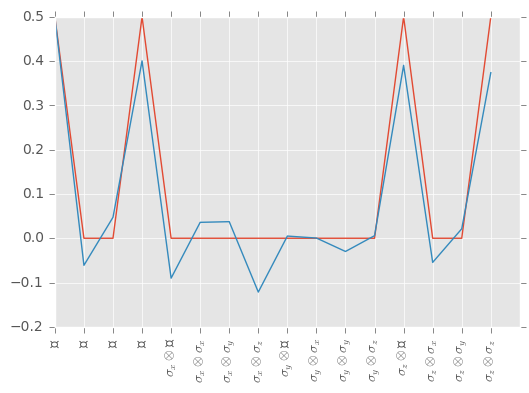

In [37]:
plt.plot(true_mps[0])
plt.plot(updater.est_mean())
plt.xticks(np.arange(16), map(u"${}$".format, basis.labels), rotation='vertical');

In [38]:
ideal_data = np.zeros_like(GS_2)
reconstructed_data = np.zeros_like(GS_2)
reconstructed_credible = np.zeros(GS_2.shape + (2,))

for idx_batch in range(number_of_batches):
    for idx_experiment, experiment in enumerate(expparams[:, np.newaxis]):
        ideal_data[idx_experiment] = model.simulate_experiment(true_mps, experiment)
        reconstructed_data[idx_experiment] = model.simulate_experiment(updater.est_mean()[None], experiment)
        reconstructed_credible[idx_experiment] = quantile_range(
            lower=0.025, upper=1 - 0.025
        )(
            model.simulate_experiment(updater.sample(1000), experiment)[0, :, 0],
            axis=0
        )

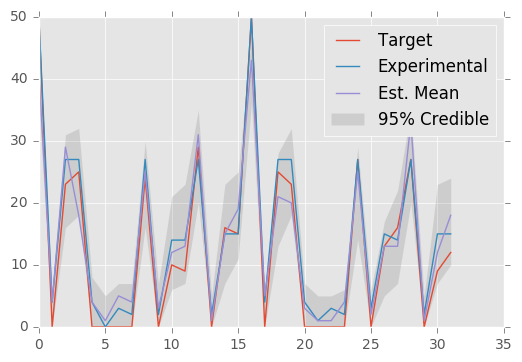

In [39]:
plt.plot(ideal_data, label='Target')
plt.plot(exp_data, label='Experimental')
plt.plot(reconstructed_data, label='Est. Mean')
plt.fill_between(
    x=np.arange(len(exp_data)),
    y1=reconstructed_credible[:, 0],
    y2=reconstructed_credible[:, 1],
    alpha=0.1,
    facecolor='k',
    label='95% Credible'
)
plt.legend()

# plt.figure()
# plt.plot(np.abs(ideal_data - exp_data))

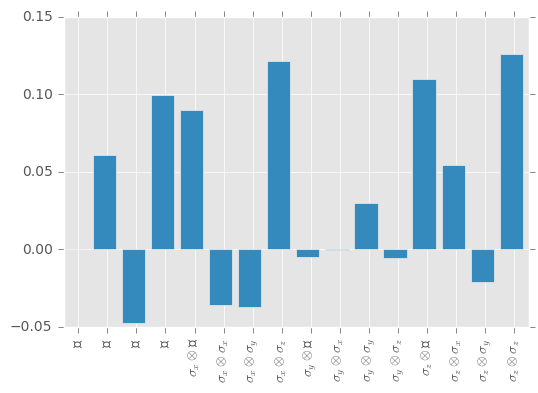

In [40]:
plt.bar(np.arange(16), (true_mps - updater.est_mean())[0, :])
plt.xticks(np.arange(16) + 0.5, map(u"${}$".format, basis.labels), rotation='vertical');

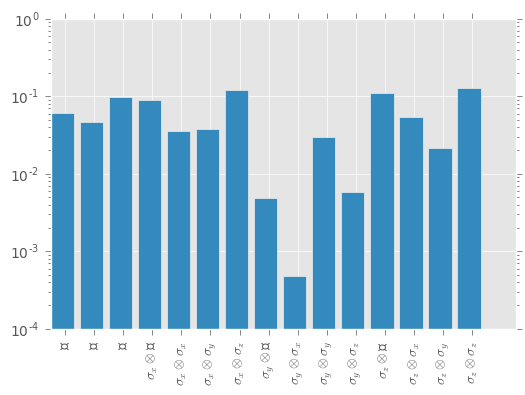

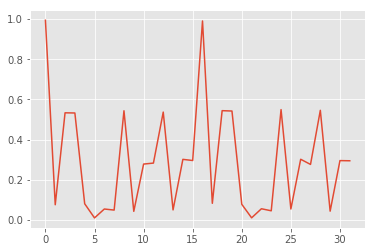

In [702]:
plt.plot((GS_2[0:32]))
# plt.show()
# plt.plot(test_data)